# **Preprocesamiento y modelado de datos de viviendas**

## **Importación de librerías y carga de datos**

In [7]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.base import clone
import optuna
import pickle
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

## **Carga del dataset original (2011–2024)**

In [8]:
df_inicial = pd.read_csv("../data/final/viviendas_2011_2024.csv")
df_inicial.columns

Index(['Ano', 'Distrito', 'Esperanza_vida', 'Renta_neta_persona',
       'Renta_neta_hogar', 'Renta_bruta_persona', 'Renta_bruta_hogar',
       'Edad_media', 'Mayores_65anos%', 'Menores_18anos%',
       'Tamano_vivienda_personas', 'Paro_registrado%',
       'Apartamentos_turisticos', 'Superficie_distrito_ha',
       'Densidad_poblacion', 'Zonas_verdes%', 'Habitaciones', 'Operacion',
       'Tamano', 'Garaje', 'Trastero', 'Piscina', 'Terraza', 'Planta',
       'Exterior', 'Ascensor', 'Ano_construccion', 'Ano_reforma',
       'Tipo_vivienda', 'Banos', 'Precio_predicho', 'Precio_ajustado'],
      dtype='object')

## **Preprocesamiento**

En esta sección se realiza una **limpieza inicial del dataset** para conservar únicamente las variables útiles y mejorar la calidad de los datos:

- **Filtrado temporal:** se conservan solo los registros desde el año **2015**.
- **Eliminación de columnas con exceso de nulos:** se eliminan `Ano_construccion` y `Ano_reforma`.
- **Creación de un indicador de nulos:** se añade `Planta_is_missing` para identificar los casos con valores faltantes en `Planta`.
- **Imputación de valores faltantes:** se imputan los valores nulos de `Planta` con la **mediana por distrito**.
- **Eliminación de variables altamente correlacionadas:** se retiran variables redundantes que no serán utilizadas en el modelado.
- **Verificación final:** se muestran las columnas restantes tras la limpieza.


NOTA: Revisar notebook [EDA_viviendas_2011_2024](./EDA_viviendas_2011_2024.ipynb) para visualizar el análisis que da lugar a las decisiones tomadas en el preprocesamiento.

In [9]:
df = df_inicial.copy()

df = df[df['Ano'] >= 2015]

# Elminación de Ano_construccion y Ano_reforma por exceso de nulos
df = df.drop(columns=['Ano_construccion', 'Ano_reforma'])

# Crear columna de indicador de nulos para Planta
df['Planta_is_missing'] = df['Planta'].isna().astype(int)

# Imputar valores nulos con la mediana para Planta (por distrito)
df['Planta'] = df.groupby('Distrito')['Planta'].transform(lambda x: x.fillna(x.median()))

# Variables muy correlacionadas y no usadas
var_corr = ['Tamano_vivienda_personas', 'Densidad_poblacion', 'Edad_media', 'Renta_neta_persona',
            'Renta_neta_hogar', 'Renta_bruta_persona', 'Renta_bruta_hogar', 'Precio_predicho']

df = df.drop(columns=var_corr)

print('Columnas restantes:', df.columns.to_list())

Columnas restantes: ['Ano', 'Distrito', 'Esperanza_vida', 'Mayores_65anos%', 'Menores_18anos%', 'Paro_registrado%', 'Apartamentos_turisticos', 'Superficie_distrito_ha', 'Zonas_verdes%', 'Habitaciones', 'Operacion', 'Tamano', 'Garaje', 'Trastero', 'Piscina', 'Terraza', 'Planta', 'Exterior', 'Ascensor', 'Tipo_vivienda', 'Banos', 'Precio_ajustado', 'Planta_is_missing']


En esta etapa se calcula la **tendencia temporal (pendiente lineal)** de diversas variables socioeconómicas y demográficas a lo largo de los años, para cada distrito.

**Proceso:**
- Se define la función `calcular_tendencia`, que ajusta un **modelo de regresión lineal simple** (`LinearRegression`) entre el año (`Ano`) y cada variable de interés.
- Para cada variable:
  - Si los valores son **constantes** a lo largo del tiempo, la tendencia se define como `0.0`.
  - Si existen suficientes datos y variabilidad en `Ano`, se calcula la **pendiente** del modelo (`coef_[0]`), que representa la tasa de cambio anual.
  - Si no hay suficientes datos, se asigna `NaN`.

**Variables consideradas:**
- `Esperanza_vida`  
- `Mayores_65anos%`  
- `Menores_18anos%`  
- `Paro_registrado%`  
- `Apartamentos_turisticos`  
- `Superficie_distrito_ha`  
- `Zonas_verdes%`

El resultado final es un **DataFrame de tendencias por distrito**, donde cada columna indica la **variación anual promedio** de la variable correspondiente.

In [10]:
def calcular_tendencia(grupo, cols):
    X = grupo['Ano'].values.reshape(-1, 1)
    tendencias = {}
    for c in cols:
        y = grupo[c].values
        if np.allclose(y, y[0], atol=1e-8):  # valores constantes
            tendencias[c] = 0.0
        elif len(np.unique(X)) > 1:
            modelo = LinearRegression().fit(X, y)
            tendencias[c] = modelo.coef_[0]
        else:
            tendencias[c] = np.nan
    return pd.Series(tendencias)

variables = ['Esperanza_vida', 'Mayores_65anos%',
       'Menores_18anos%', 'Paro_registrado%', 'Apartamentos_turisticos',
       'Superficie_distrito_ha', 'Zonas_verdes%']
cols = ['Ano'] + variables
tendencias = df.dropna().groupby('Distrito')[cols].apply(calcular_tendencia, cols=variables).reset_index()

In [11]:
tendencias

,Distrito,Esperanza_vida,Mayores_65anos%,Menores_18anos%,Paro_registrado%,Apartamentos_turisticos,Superficie_distrito_ha,Zonas_verdes%
0,ARGANZUELA,-0.015476,0.003429,-0.002690,-0.002182,0.142857,0.0,0.0
1,BARAJAS,0.119048,0.002905,-0.002274,-0.001530,0.083333,0.0,0.0
2,CARABANCHEL,0.027381,-0.002262,-0.001845,-0.002469,0.547619,0.0,0.0
3,CENTRO,0.067857,-0.000940,-0.002607,-0.002150,3.404762,0.0,0.0
4,CHAMARTIN,0.032143,0.001143,-0.000310,-0.001232,0.190476,0.0,0.0
5,CHAMBERI,0.075000,0.000405,-0.001024,-0.001527,0.321429,0.0,0.0
6,CIUDADLINEAL,0.009524,-0.000619,-0.002143,-0.002183,0.285714,0.0,0.0
7,FUENCARRALELPARDO,0.041667,0.001774,0.000071,-0.001628,0.000000,0.0,0.0
8,HORTALEZA,0.091667,0.000214,0.000071,-0.001832,0.083333,0.0,0.0
9,LATINA,-0.019048,-0.002083,-0.001250,-0.002176,0.000000,0.0,0.0


In [12]:
tendencias.to_csv("../data/final/tendencias.csv")

## **Imputación de valores faltantes mediante tendencias por distrito**

En esta sección se utilizan las **tendencias lineales calculadas previamente** para imputar los valores faltantes de ciertas variables socioeconómicas a nivel de distrito.

**Resultado:**  
Un dataset sin valores nulos en las variables seleccionadas, imputadas de forma coherente con la evolución temporal observada en cada distrito.


In [13]:
# Renombrar columnas de tendencias para evitar confusión
tendencias_rename = {var: f'{var}_tendencia' for var in variables}
tendencias = tendencias.rename(columns=tendencias_rename)

# Aplicar por distrito (agregado include_groups=False)
vars_faltantes = ['Mayores_65anos%', 'Menores_18anos%', 'Paro_registrado%']

# Seleccionar solo columna Distrito y las tendencias que necesitamos
tendencias_merge = tendencias[['Distrito'] + [f'{var}_tendencia' for var in vars_faltantes]]

# Merge limpio
df = df.merge(tendencias_merge, on='Distrito', how='left')

# Crear indicadores de nulos
for var in vars_faltantes:
    df[f"{var}_is_missing"] = df[var].isna().astype(int)

# Función de imputación con tendencia
def imputar_con_tendencia(grupo, var):

    # Pendiente anual (tasa de cambio por año) a usar para extrapolación futura.
    tendencia = grupo[f'{var}_tendencia'].iloc[0]
    ultimo_valido = grupo[var].last_valid_index()
    
    # Si existe al menos un dato observado, extrapola SOLO para años posteriores.
    if ultimo_valido is not None:
        
        # Último valor y su año de referencia (punto base para la extrapolación lineal).
        ultimo_valor = grupo.loc[ultimo_valido, var]
        ultimo_ano = grupo.loc[ultimo_valido, 'Ano']
        
        # Imputa valores nulos en años futuros (> último_ano) extrapolando linealmente desde el último valor conocido usando la tendencia.
        mask_futuro = grupo[var].isna() & (grupo['Ano'] > ultimo_ano)
        grupo.loc[mask_futuro, var] = (ultimo_valor + tendencia * (grupo.loc[mask_futuro, 'Ano'] - ultimo_ano))
    
    # Relleno final de nulos restantes: ffill/bfill para nulos restantes
    return grupo[var].ffill().bfill()

for var in vars_faltantes:
    df[var] = df.groupby('Distrito', group_keys=False).apply(lambda g: imputar_con_tendencia(g, var), include_groups=False)

En esta última etapa se realiza una **limpieza posterior a la imputación** y una verificación general del estado del dataset.

**Eliminación de columnas auxiliares de tendencia:**  
   Las columnas utilizadas para la imputación (`*_tendencia`) ya no son necesarias,  
   por lo que se eliminan del DataFrame.

In [14]:
# Eliminar columnas de tendencias que ya no son necesarias tras la imputación
cols_tendencia = [col for col in df.columns if '_tendencia' in col]
df = df.drop(columns=cols_tendencia)

# Verificar estado final del dataset: tipos de datos y ausencia de nulos
resumen = pd.DataFrame({"Tipo": df.dtypes, "Nulos": df.isna().sum(), "Nulos_%": (df.isna().mean()*100).round(2)})
print(resumen)

                                Tipo  Nulos  Nulos_%
Ano                            int64      0      0.0
Distrito                      object      0      0.0
Esperanza_vida               float64      0      0.0
Mayores_65anos%              float64      0      0.0
Menores_18anos%              float64      0      0.0
Paro_registrado%             float64      0      0.0
Apartamentos_turisticos      float64      0      0.0
Superficie_distrito_ha       float64      0      0.0
Zonas_verdes%                float64      0      0.0
Habitaciones                   int64      0      0.0
Operacion                     object      0      0.0
Tamano                       float64      0      0.0
Garaje                          bool      0      0.0
Trastero                        bool      0      0.0
Piscina                         bool      0      0.0
Terraza                         bool      0      0.0
Planta                       float64      0      0.0
Exterior                        bool      0   

## **Creación de variables temporales y de contexto de mercado**

En esta sección se generan **nuevas características (features)** que capturan la **dinámica temporal y espacial del mercado inmobiliario**, con el fin de enriquecer el modelo predictivo.

**Resultado:**  
Se añaden múltiples **features temporales y de contexto local** que capturan la evolución de los precios, la estabilidad del mercado y la posición relativa de cada vivienda dentro de su entorno.

In [15]:
# Ordenar el dataframe por las columnas clave para calcular correctamente los lags temporales
df = df.sort_values(['Distrito', 'Tipo_vivienda', 'Ano']).reset_index(drop=True)

# --- FEATURE 1: Precio promedio año anterior por Distrito + Tipo_vivienda ---
# Compara cada vivienda con el precio medio de viviendas similares del año anterior
df['precio_prom_ano_ant'] = (df.groupby(['Distrito', 'Tipo_vivienda'])['Precio_ajustado'].shift(1))

# --- FEATURE 2: Tendencia de precio por Distrito (cambio porcentual) ---
# Captura la dinámica del mercado en cada distrito
df['tendencia_distrito'] = (
    df.groupby('Distrito')['Precio_ajustado']
    .pct_change()  # Variación porcentual respecto al periodo anterior
)

# --- FEATURE 3: Precio por m² del año anterior por Distrito ---
# Normaliza por tamaño para comparar valor relativo
df['precio_m2'] = df['Precio_ajustado'] / df['Tamano']
df['precio_m2_distrito_ant'] = (
    df.groupby('Distrito')['precio_m2']
    .shift(1)
)

# Eliminar columna auxiliar
df = df.drop(columns=['precio_m2'])

# --- FEATURES 4 y 5: Ratio de precio año anterior y volatilidad año anterior
# Calcular promedio y volatilidad por distrito y año
agg = (
    df.groupby(['Distrito', 'Ano'])['Precio_ajustado']
      .agg(['mean', 'std'])
      .rename(columns={'mean': 'precio_prom_distrito', 'std': 'volatilidad_distrito'})
      .reset_index()
)

# Ordenar para asegurar desplazamiento correcto
agg = agg.sort_values(['Distrito', 'Ano'])

# Crear versiones lagged (t-1) por distrito
agg['precio_prom_distrito_ano_ant'] = (
    agg.groupby('Distrito')['precio_prom_distrito'].shift(1)
)
agg['volatilidad_distrito_ano_ant'] = (
    agg.groupby('Distrito')['volatilidad_distrito'].shift(1)
)

# Mantener solo las columnas necesarias para el merge
agg = agg[['Distrito', 'Ano', 'precio_prom_distrito_ano_ant', 'volatilidad_distrito_ano_ant']]

# Incorporar al dataframe principal
df = df.merge(agg, on=['Distrito', 'Ano'], how='left')

# Crear el ratio basado en el promedio del año anterior
df['ratio_vs_distrito_ano_ant'] = (
    df['Precio_ajustado'] / df['precio_prom_distrito_ano_ant']
)

# Si hay NaN en los primeros años (sin año previo), rellenar con la media global
df['precio_prom_distrito_ano_ant'] = df['precio_prom_distrito_ano_ant'].fillna(df['precio_prom_distrito_ano_ant'].median())
df['ratio_vs_distrito_ano_ant'] = df['ratio_vs_distrito_ano_ant'].fillna(df['ratio_vs_distrito_ano_ant'].median())
df['volatilidad_distrito_ano_ant'] = df['volatilidad_distrito_ano_ant'].fillna(df['volatilidad_distrito_ano_ant'].median())


# Imputar nulos resultantes de los lags (primer año de cada grupo)
# Usamos mediana por distrito para mantener coherencia espacial
for col in ['precio_prom_ano_ant', 'tendencia_distrito', 'precio_m2_distrito_ant']:
    if col in df.columns:
        df[col] = df.groupby('Distrito')[col].transform(lambda x: x.fillna(x.median()))

print("Features temporales agregadas creadas correctamente")
print(f"Nuevas columnas: {[c for c in df.columns if 'prom_ano' in c or 'tendencia' in c or 'm2_distrito' in c or 'ratio_vs' in c or 'volatilidad' in c]}")

Features temporales agregadas creadas correctamente
Nuevas columnas: ['precio_prom_ano_ant', 'tendencia_distrito', 'precio_m2_distrito_ant', 'volatilidad_distrito_ano_ant', 'ratio_vs_distrito_ano_ant']


## **Preparación del dataset y configuración del entrenamiento**

En esta sección se preparan los datos y la configuración necesaria para entrenar y evaluar distintos modelos predictivos.  
El objetivo es construir un flujo de trabajo **reproducible, limpio y compatible con validación temporal.**

**Resultado:**  
Dataset y entorno de entrenamiento completamente configurados, con los modelos listos para iniciar la fase de validación y comparación de desempeño.

In [16]:
# --- 1. Encoding de variables categóricas ---
df = pd.get_dummies(df, drop_first=True)
print(f"Shape después de get_dummies: {df.shape}")

# --- 2. Preparar dataset ---
df = df.sort_values(by="Ano").reset_index(drop=True)
df = df.dropna(subset=["Precio_ajustado"])
print(f"Dataset ordenado y limpio: {df.shape}")

# --- 3. Definir X / y ---
TARGET_COL = "Precio_ajustado"
DROP_COLS = [TARGET_COL]

FEATURES = [c for c in df.columns if c not in DROP_COLS]
print(f"Total de features: {len(FEATURES)}")

# --- 4. Separación temporal y por venta y alquiler---
mask_train_venta = (df["Ano"] <= 2022) & (df['Operacion_venta'] == 1)
mask_train_alquiler = (df["Ano"] <= 2022) & (df['Operacion_venta'] == 0)
mask_test_venta = (df["Ano"] >= 2023) & (df['Operacion_venta'] == 1)
mask_test_alquiler = (df["Ano"] >= 2023) & (df['Operacion_venta'] == 0)

X_train_venta = df.loc[mask_train_venta, FEATURES]
y_train_venta = df.loc[mask_train_venta, TARGET_COL]
X_train_alquiler = df.loc[mask_train_alquiler, FEATURES]
y_train_alquiler = df.loc[mask_train_alquiler, TARGET_COL]

X_test_venta = df.loc[mask_test_venta, FEATURES]
y_test_venta = df.loc[mask_test_venta, TARGET_COL]
X_test_alquiler = df.loc[mask_test_alquiler, FEATURES]
y_test_alquiler = df.loc[mask_test_alquiler, TARGET_COL]

print(f"Train venta: {X_train_venta.shape}, Test venta: {X_test_venta.shape}")
print(f"Train alquiler: {X_train_alquiler.shape}, Test alquiler: {X_test_alquiler.shape}")

# --- 5. Definir pipeline (UNA SOLA VEZ) ---
def definir_pipeline(modelo, usar_scaler=False) -> Pipeline:
    """
    Realiza escalado robusto (opcional) y aplica el modelo elegido.
    
    Parameters
    ----------
    modelo : estimator
        Modelo de sklearn (Ridge, RandomForest, etc.)
    
    usar_scaler : bool
        _True_ si se desea usar RobustScaler. _False_ si no se desea usar.
        Útil solo para modelos lineales, basados en distancia y MLP.
    
    Returns
    -------
    pipeline : Pipeline
        Pipeline con escalado (opcional) + modelo.
    """
    steps = []
    if usar_scaler:
        steps.append(('scaler', RobustScaler()))
    steps.append(('modelo', modelo))

    return Pipeline(steps)

# --- 6. Función de evaluación ---
def evaluar(model, X_tr, y_tr, X_va, y_va):
    """
    Entrena y evalúa un modelo con métricas completas.
    """
    model.fit(X_tr, y_tr)
    pred_tr = model.predict(X_tr)
    pred_va = model.predict(X_va)

    return {
        "MAE_train": mean_absolute_error(y_tr, pred_tr),
        "RMSE_train": np.sqrt(mean_squared_error(y_tr, pred_tr)),
        "R2_train": r2_score(y_tr, pred_tr),
        "MAE_val": mean_absolute_error(y_va, pred_va),
        "RMSE_val": np.sqrt(mean_squared_error(y_va, pred_va)),
        "MAPE_val_%": mean_absolute_percentage_error(y_va, pred_va) * 100,
        "R2_val": r2_score(y_va, pred_va),
    }

# --- 7. Definir modelos ---
modelos = {
    "ridge": definir_pipeline(Ridge(alpha=1.0, random_state=42), usar_scaler=True),
    "knn":   definir_pipeline(KNeighborsRegressor(n_neighbors=7, weights="distance", n_jobs=-1), usar_scaler=True),
    "hgb":   definir_pipeline(HistGradientBoostingRegressor(loss="absolute_error",
                max_depth=15, learning_rate=0.06, max_iter=500, random_state=42)),
    "lgbm":  definir_pipeline(LGBMRegressor(n_estimators=1000, learning_rate=0.05,
                subsample=0.8, colsample_bytree=0.8, force_row_wise=True,
                verbosity=-1, n_jobs=-1, random_state=42)),
    "mlp":   definir_pipeline(MLPRegressor(
                hidden_layer_sizes=(64, 32),
                max_iter=800,
                activation="relu",
                learning_rate_init=1e-3,
                early_stopping=True,
                n_iter_no_change=10,
                random_state=42), usar_scaler=True),
}

# --- 8. Validación temporal con TimeSeriesSplit ---
splits = 5
tscv = TimeSeriesSplit(n_splits=splits)
resultados_venta = {}
entrenados_venta = {}
resultados_alquiler = {}
entrenados_alquiler = {}

print("Setup completado. Listo para entrenar modelos.")

Shape después de get_dummies: (149440, 57)
Dataset ordenado y limpio: (149440, 57)
Total de features: 56
Train venta: (73504, 56), Test venta: (18376, 56)
Train alquiler: (46048, 56), Test alquiler: (11512, 56)
Setup completado. Listo para entrenar modelos.


## **Entrenamiento y validación temporal de modelos**

En esta sección se realiza el **entrenamiento con validación temporal** utilizando el método `TimeSeriesSplit`, asegurando que la evaluación de los modelos respete la secuencia cronológica de los datos.

**Resultado:**  
Se obtienen modelos validados temporalmente, con métricas de desempeño en distintos periodos,  
y versiones finales entrenadas con todos los datos históricos disponibles.

**Entrenamientos de prueba para VENTA y ALQUILER:**

In [11]:
print("Iniciando entrenamiento con TimeSeriesSplit...\n")

# Entrenamientos de prueba para VENTA
for nombre, pipe in modelos.items():
    print(f"Entrenando modelo: {nombre.upper()}")
    resultados_modelo = []
    n_validacion = 0
    
    for train_index, val_index in tscv.split(X_train_venta):
        n_validacion += 1
        print(f"   Split {n_validacion}/{splits}")

        pipe_cv = clone(pipe)

        X_tr, X_val = X_train_venta.iloc[train_index], X_train_venta.iloc[val_index]
        y_tr, y_val = y_train_venta.iloc[train_index], y_train_venta.iloc[val_index]
        
        metrics = evaluar(pipe_cv, X_tr, y_tr, X_val, y_val)
        resultados_modelo.append(metrics)

    resultados_venta[nombre] = resultados_modelo

    # Entrenamiento final con todo el train set
    print(f"   Fit final en {X_train_venta.shape[0]} muestras\n")
    pipe_final = clone(pipe).fit(X_train_venta, y_train_venta)
    entrenados_venta[nombre] = pipe_final

Iniciando entrenamiento con TimeSeriesSplit...

Entrenando modelo: RIDGE
   Split 1/5
   Split 2/5
   Split 3/5
   Split 4/5
   Split 5/5
   Fit final en 73504 muestras

Entrenando modelo: KNN
   Split 1/5
   Split 2/5
   Split 3/5
   Split 4/5
   Split 5/5
   Fit final en 73504 muestras

Entrenando modelo: HGB
   Split 1/5
   Split 2/5
   Split 3/5
   Split 4/5
   Split 5/5
   Fit final en 73504 muestras

Entrenando modelo: LGBM
   Split 1/5
   Split 2/5
   Split 3/5
   Split 4/5
   Split 5/5
   Fit final en 73504 muestras

Entrenando modelo: MLP
   Split 1/5
   Split 2/5
   Split 3/5
   Split 4/5
   Split 5/5
   Fit final en 73504 muestras



In [13]:
print("Iniciando entrenamiento con TimeSeriesSplit...\n")

# Entrenamientos de prueba para ALQUILER
for nombre, pipe in modelos.items():
    print(f"Entrenando modelo: {nombre.upper()}")
    resultados_modelo = []
    n_validacion = 0
    
    for train_index, val_index in tscv.split(X_train_alquiler):
        n_validacion += 1
        print(f"   Split {n_validacion}/{splits}")

        pipe_cv = clone(pipe)

        X_tr, X_val = X_train_alquiler.iloc[train_index], X_train_alquiler.iloc[val_index]
        y_tr, y_val = y_train_alquiler.iloc[train_index], y_train_alquiler.iloc[val_index]
        
        metrics = evaluar(pipe_cv, X_tr, y_tr, X_val, y_val)
        resultados_modelo.append(metrics)

    resultados_alquiler[nombre] = resultados_modelo

    # Entrenamiento final con todo el train set
    print(f"   Fit final en {X_train_alquiler.shape[0]} muestras\n")
    pipe_final = clone(pipe).fit(X_train_alquiler, y_train_alquiler)
    entrenados_alquiler[nombre] = pipe_final

Iniciando entrenamiento con TimeSeriesSplit...

Entrenando modelo: RIDGE
   Split 1/5
   Split 2/5
   Split 3/5
   Split 4/5
   Split 5/5
   Fit final en 46048 muestras

Entrenando modelo: KNN
   Split 1/5
   Split 2/5
   Split 3/5
   Split 4/5
   Split 5/5
   Fit final en 46048 muestras

Entrenando modelo: HGB
   Split 1/5
   Split 2/5
   Split 3/5
   Split 4/5
   Split 5/5
   Fit final en 46048 muestras

Entrenando modelo: LGBM
   Split 1/5
   Split 2/5
   Split 3/5
   Split 4/5
   Split 5/5
   Fit final en 46048 muestras

Entrenando modelo: MLP
   Split 1/5
   Split 2/5
   Split 3/5
   Split 4/5
   Split 5/5
   Fit final en 46048 muestras



**Mostrar resultados de validación cruzada**

En esta sección se presentan los **resultados de la validación temporal (2015–2022)** para todos los modelos entrenados.  
El objetivo es comparar su desempeño y seleccionar el modelo más prometedor según las métricas de evaluación.

Un resumen claro del rendimiento de cada modelo, destacando el mejor candidato para predicciones futuras.

In [14]:
print("\n" + "="*70)
print("RESULTADOS DE VALIDACIÓN CRUZADA DE VENTA (2015-2022)")
print("="*70)

ranking = sorted(
    resultados_venta.items(),
    key=lambda kv: min([m["MAE_val"] for m in kv[1]])
)

for nombre, metricas in ranking:
    mae_vals = [m["MAE_val"] for m in metricas]
    rmse_vals = [m["RMSE_val"] for m in metricas]
    r2_vals = [m["R2_val"] for m in metricas]
    mape_vals = [m["MAPE_val_%"] for m in metricas]

    mae_tr_vals = [m["MAE_train"] for m in metricas]
    rmse_tr_vals = [m["RMSE_train"] for m in metricas]
    r2_tr_vals = [m["R2_train"] for m in metricas]

    print(f"\n{nombre.upper()}:")
    print(f"  Validación:")
    print(f"    MAE    = {min(mae_vals):,.2f} EUR")
    print(f"    RMSE   = {min(rmse_vals):,.2f} EUR")
    print(f"    R2     = {max(r2_vals):.4f}")
    print(f"    MAPE   = {min(mape_vals):.2f}%")
    print(f"  Entrenamiento:")
    print(f"    MAE    = {min(mae_tr_vals):,.2f} EUR")
    print(f"    RMSE   = {min(rmse_tr_vals):,.2f} EUR")
    print(f"    R2     = {max(r2_tr_vals):.4f}")

mejor_nombre_venta = ranking[0][0]
mejor_modelo_venta = entrenados_venta[mejor_nombre_venta]

print("\n" + "="*70)
print(f"MEJOR MODELO: {mejor_nombre_venta.upper()}")
print("="*70)


RESULTADOS DE VALIDACIÓN CRUZADA DE VENTA (2015-2022)

LGBM:
  Validación:
    MAE    = 16,107.63 EUR
    RMSE   = 33,855.91 EUR
    R2     = 0.9959
    MAPE   = 3.88%
  Entrenamiento:
    MAE    = 7,937.94 EUR
    RMSE   = 14,287.63 EUR
    R2     = 0.9990

HGB:
  Validación:
    MAE    = 19,589.23 EUR
    RMSE   = 104,686.64 EUR
    R2     = 0.9717
    MAPE   = 2.92%
  Entrenamiento:
    MAE    = 13,616.54 EUR
    RMSE   = 76,919.24 EUR
    R2     = 0.9767

MLP:
  Validación:
    MAE    = 38,147.52 EUR
    RMSE   = 71,809.93 EUR
    R2     = 0.9816
    MAPE   = 9.29%
  Entrenamiento:
    MAE    = 37,989.26 EUR
    RMSE   = 83,757.19 EUR
    R2     = 0.9716

KNN:
  Validación:
    MAE    = 48,581.07 EUR
    RMSE   = 87,540.60 EUR
    R2     = 0.9770
    MAPE   = 10.14%
  Entrenamiento:
    MAE    = 0.01 EUR
    RMSE   = 0.08 EUR
    R2     = 1.0000

RIDGE:
  Validación:
    MAE    = 96,629.83 EUR
    RMSE   = 155,845.68 EUR
    R2     = 0.9187
    MAPE   = 27.92%
  Entrenamiento:
   

In [15]:
print("\n" + "="*70)
print("RESULTADOS DE VALIDACIÓN CRUZADA DE ALQUILER (2015-2022)")
print("="*70)

ranking = sorted(
    resultados_alquiler.items(),
    key=lambda kv: min([m["MAE_val"] for m in kv[1]])
)

for nombre, metricas in ranking:
    mae_vals = [m["MAE_val"] for m in metricas]
    rmse_vals = [m["RMSE_val"] for m in metricas]
    r2_vals = [m["R2_val"] for m in metricas]
    mape_vals = [m["MAPE_val_%"] for m in metricas]

    mae_tr_vals = [m["MAE_train"] for m in metricas]
    rmse_tr_vals = [m["RMSE_train"] for m in metricas]
    r2_tr_vals = [m["R2_train"] for m in metricas]

    print(f"\n{nombre.upper()}:")
    print(f"  Validación:")
    print(f"    MAE    = {min(mae_vals):,.2f} EUR")
    print(f"    RMSE   = {min(rmse_vals):,.2f} EUR")
    print(f"    R2     = {max(r2_vals):.4f}")
    print(f"    MAPE   = {min(mape_vals):.2f}%")
    print(f"  Entrenamiento:")
    print(f"    MAE    = {min(mae_tr_vals):,.2f} EUR")
    print(f"    RMSE   = {min(rmse_tr_vals):,.2f} EUR")
    print(f"    R2     = {max(r2_tr_vals):.4f}")

mejor_nombre_alquiler = ranking[0][0]
mejor_modelo_alquiler = entrenados_alquiler[mejor_nombre_alquiler]

print("\n" + "="*70)
print(f"MEJOR MODELO: {mejor_nombre_alquiler.upper()}")
print("="*70)


RESULTADOS DE VALIDACIÓN CRUZADA DE ALQUILER (2015-2022)

LGBM:
  Validación:
    MAE    = 30.28 EUR
    RMSE   = 62.60 EUR
    R2     = 0.9969
    MAPE   = 1.93%
  Entrenamiento:
    MAE    = 15.95 EUR
    RMSE   = 28.28 EUR
    R2     = 0.9992

HGB:
  Validación:
    MAE    = 35.86 EUR
    RMSE   = 108.52 EUR
    R2     = 0.9906
    MAPE   = 1.89%
  Entrenamiento:
    MAE    = 30.53 EUR
    RMSE   = 119.21 EUR
    R2     = 0.9877

MLP:
  Validación:
    MAE    = 77.35 EUR
    RMSE   = 140.58 EUR
    R2     = 0.9843
    MAPE   = 5.66%
  Entrenamiento:
    MAE    = 79.59 EUR
    RMSE   = 165.01 EUR
    R2     = 0.9768

KNN:
  Validación:
    MAE    = 123.13 EUR
    RMSE   = 189.96 EUR
    R2     = 0.9713
    MAPE   = 8.61%
  Entrenamiento:
    MAE    = 0.00 EUR
    RMSE   = 0.00 EUR
    R2     = 1.0000

RIDGE:
  Validación:
    MAE    = 316.08 EUR
    RMSE   = 530.28 EUR
    R2     = 0.7945
    MAPE   = 21.83%
  Entrenamiento:
    MAE    = 240.74 EUR
    RMSE   = 408.19 EUR
    R2    

## **Optimización de hiperparámetros con Optuna (LGBM)**

En esta sección se realiza la **optimización automática de hiperparámetros** del mejor modelo utilizando la librería **Optuna**, con el objetivo de minimizar el error medio absoluto (MAE) en validación temporal.

**Resultado:**  
Un modelo optimizado mediante búsqueda automática de hiperparámetros,  
validado temporalmente y listo para compararse con los demás modelos base.

In [16]:
def objective_lgbm_venta(trial):
    """
    Función objetivo para Optuna: minimiza MAE promedio en validación cruzada.
    """
    params = {
        "objective": "regression",
        "metric": "mae",
        "verbose": -1,
        "boosting_type": "gbdt",
        "n_estimators": trial.suggest_int("n_estimators", 500, 1000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 15, 255),
        "max_depth": -1,
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100, step=5),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 0.3),
        "feature_fraction_bynode": trial.suggest_float("feature_fraction_bynode", 0.6, 1.0),
        "random_state": 42,
        "n_jobs": -1,
    }

    pipe = definir_pipeline(LGBMRegressor(**params))

    maes = []
    for train_idx, val_idx in tscv.split(X_train_venta):
        pipe_cv = clone(pipe)

        X_tr, X_val = X_train_venta.iloc[train_idx], X_train_venta.iloc[val_idx]
        y_tr, y_val = y_train_venta.iloc[train_idx], y_train_venta.iloc[val_idx]
        
        mets = evaluar(pipe_cv, X_tr, y_tr, X_val, y_val)
        maes.append(mets["MAE_val"])

    return np.mean(maes)

def objective_lgbm_alquiler(trial):
    """
    Función objetivo para Optuna: minimiza MAE promedio en validación cruzada.
    """
    params = {
        "objective": "regression",
        "metric": "mae",
        "verbose": -1,
        "boosting_type": "gbdt",
        "n_estimators": trial.suggest_int("n_estimators", 500, 1000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 15, 255),
        "max_depth": -1,
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100, step=5),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 0.3),
        "feature_fraction_bynode": trial.suggest_float("feature_fraction_bynode", 0.6, 1.0),
        "random_state": 42,
        "n_jobs": -1,
    }

    pipe = definir_pipeline(LGBMRegressor(**params))

    maes = []
    for train_idx, val_idx in tscv.split(X_train_alquiler):
        pipe_cv = clone(pipe)

        X_tr, X_val = X_train_alquiler.iloc[train_idx], X_train_alquiler.iloc[val_idx]
        y_tr, y_val = y_train_alquiler.iloc[train_idx], y_train_alquiler.iloc[val_idx]
        
        mets = evaluar(pipe_cv, X_tr, y_tr, X_val, y_val)
        maes.append(mets["MAE_val"])

    return np.mean(maes)

In [17]:
print("\nIniciando optimización de hiperparámetros para VENTA con Optuna...")
print(f"Usando TimeSeriesSplit con {splits} splits\n")

# Crear estudio de Optuna para VENTA
study_venta = optuna.create_study(direction="minimize", study_name="Optimizacion_LGBM_venta")
study_venta.optimize(objective_lgbm_venta, n_trials=40, show_progress_bar=True)

print("\n" + "="*70)
print("RESULTADOS DE OPTIMIZACIÓN")
print("="*70)
print(f"Mejor MAE validación: {study_venta.best_value:,.2f} EUR")
print(f"\nMejores hiperparámetros:")
for param, value in study_venta.best_params.items():
    print(f"  {param}: {value}")

[I 2025-10-17 14:57:47,438] A new study created in memory with name: Optimizacion_LGBM_venta



Iniciando optimización de hiperparámetros para VENTA con Optuna...
Usando TimeSeriesSplit con 5 splits



  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-10-17 14:58:41,817] Trial 0 finished with value: 22952.134322577018 and parameters: {'n_estimators': 1000, 'learning_rate': 0.01707732138196509, 'num_leaves': 147, 'min_child_samples': 80, 'subsample': 0.6503691147510144, 'colsample_bytree': 0.7788245235504607, 'reg_alpha': 3.8366105887968226e-05, 'reg_lambda': 0.038123864896418704, 'min_split_gain': 0.21865238498371392, 'feature_fraction_bynode': 0.814971188298215}. Best is trial 0 with value: 22952.134322577018.
[I 2025-10-17 14:59:42,811] Trial 1 finished with value: 21249.2534367954 and parameters: {'n_estimators': 800, 'learning_rate': 0.041131325047743306, 'num_leaves': 206, 'min_child_samples': 30, 'subsample': 0.8307515975940633, 'colsample_bytree': 0.7404671939450155, 'reg_alpha': 6.997066359599182, 'reg_lambda': 0.6627193375455431, 'min_split_gain': 0.12063517085784797, 'feature_fraction_bynode': 0.8856781698694153}. Best is trial 1 with value: 21249.2534367954.
[I 2025-10-17 15:00:28,734] Trial 2 finished with value:

In [18]:
print("\nIniciando optimización de hiperparámetros para ALQUILER con Optuna...")
print(f"Usando TimeSeriesSplit con {splits} splits\n")

# Crear estudio de Optuna para ALQUILER
study_alquiler = optuna.create_study(direction="minimize", study_name="Optimizacion_LGBM_alquiler")
study_alquiler.optimize(objective_lgbm_alquiler, n_trials=40, show_progress_bar=True)

print("\n" + "="*70)
print("RESULTADOS DE OPTIMIZACIÓN")
print("="*70)
print(f"Mejor MAE validación: {study_alquiler.best_value:,.2f} EUR")
print(f"\nMejores hiperparámetros:")
for param, value in study_alquiler.best_params.items():
    print(f"  {param}: {value}")

[I 2025-10-17 15:25:05,904] A new study created in memory with name: Optimizacion_LGBM_alquiler



Iniciando optimización de hiperparámetros para ALQUILER con Optuna...
Usando TimeSeriesSplit con 5 splits



  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-10-17 15:25:22,100] Trial 0 finished with value: 43.4479353972816 and parameters: {'n_estimators': 600, 'learning_rate': 0.029670051346688302, 'num_leaves': 94, 'min_child_samples': 15, 'subsample': 0.705659678028996, 'colsample_bytree': 0.7594323667993828, 'reg_alpha': 3.72168622746146e-05, 'reg_lambda': 1.2501240912404465, 'min_split_gain': 0.029142754604570928, 'feature_fraction_bynode': 0.9842271749875672}. Best is trial 0 with value: 43.4479353972816.
[I 2025-10-17 15:25:37,913] Trial 1 finished with value: 44.16733436841736 and parameters: {'n_estimators': 800, 'learning_rate': 0.09208019058289885, 'num_leaves': 65, 'min_child_samples': 50, 'subsample': 0.9888875872982987, 'colsample_bytree': 0.9721517577735777, 'reg_alpha': 1.6527793481127143e-08, 'reg_lambda': 0.023748898670686257, 'min_split_gain': 0.14673883668577772, 'feature_fraction_bynode': 0.898038266539495}. Best is trial 0 with value: 43.4479353972816.
[I 2025-10-17 15:25:49,585] Trial 2 finished with value: 51

**Entrenamiento del modelo Random Forest final con los mejores hiperparámetros**

Se entrena el modelo Random Forest utilizando los hiperparámetros óptimos encontrados con Optuna. El modelo final se integra en un pipeline con escalado robusto y se ajusta sobre los datos de entrenamiento completos, obteniendo así la versión definitiva lista para evaluación y predicciones futuras.

In [19]:
# ===== Entrenar el mejor modelo final =====
lgbm_final_venta = definir_pipeline(LGBMRegressor(**study_venta.best_params, n_jobs=-1, random_state=42))
lgbm_final_alquiler = definir_pipeline(LGBMRegressor(**study_alquiler.best_params, n_jobs=-1, random_state=42))

# Entrenar con todos los datos (ya que es una serie temporal)
lgbm_final_venta.fit(X_train_venta, y_train_venta)
lgbm_final_alquiler.fit(X_train_alquiler, y_train_alquiler)

,steps,"[('modelo', ...)]"
,transform_input,None
,memory,None
,verbose,False
,boosting_type,'gbdt'
,num_leaves,217
,max_depth,-1
,learning_rate,0.04900114778165227
,n_estimators,1000
,subsample_for_bin,200000
,objective,None


Guardar modelos

In [21]:
with open('../models/lgbm_final_venta.pkl', 'wb') as f:
    pickle.dump(lgbm_final_venta, f)

In [22]:
with open('../models/lgbm_final_alquiler.pkl', 'wb') as f:
    pickle.dump(lgbm_final_alquiler, f)

Cargar modelo

In [3]:
with open('../models/lgbm_final_venta.pkl', 'rb') as f:
    lgbm_final_venta = pickle.load(f)
with open('../models/lgbm_final_alquiler.pkl', 'rb') as f:
    lgbm_final_alquiler = pickle.load(f)

**Análisis de la importancia de variables en el modelo Random Forest**

Se extraen y visualizan las variables con mayor peso en el modelo final de Random Forest. Este análisis permite identificar los factores que más influyen en la predicción del precio ajustado, mostrando las 15 variables más relevantes mediante una tabla y un gráfico de barras.

,Variable,Importancia
27,ratio_vs_distrito_ano_ant,6.615777e+16
22,precio_prom_ano_ant,5.719408e+16
9,Tamano,5.420703e+16
25,precio_prom_distrito_ano_ant,1.338283e+16
23,tendencia_distrito,1.053046e+16
26,volatilidad_distrito_ano_ant,8.770723e+15
8,Habitaciones,4.251113e+15
24,precio_m2_distrito_ant,2.329547e+15
4,Paro_registrado%,2.076823e+15
7,Zonas_verdes%,1.819666e+15


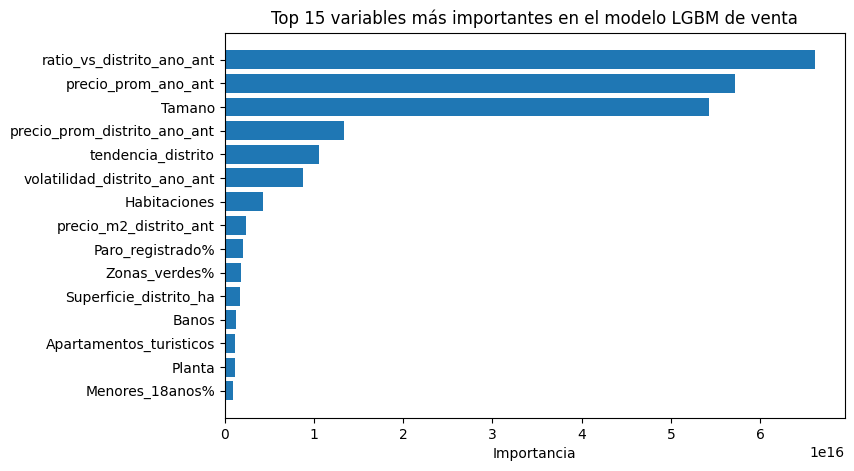

,Variable,Importancia
9,Tamano,3.095520e+11
23,tendencia_distrito,1.057517e+11
27,ratio_vs_distrito_ano_ant,5.311509e+10
22,precio_prom_ano_ant,4.434630e+10
25,precio_prom_distrito_ano_ant,2.238639e+10
26,volatilidad_distrito_ano_ant,1.394993e+10
8,Habitaciones,3.851779e+09
3,Menores_18anos%,3.721915e+09
5,Apartamentos_turisticos,3.662952e+09
41,Distrito_SALAMANCA,3.258912e+09


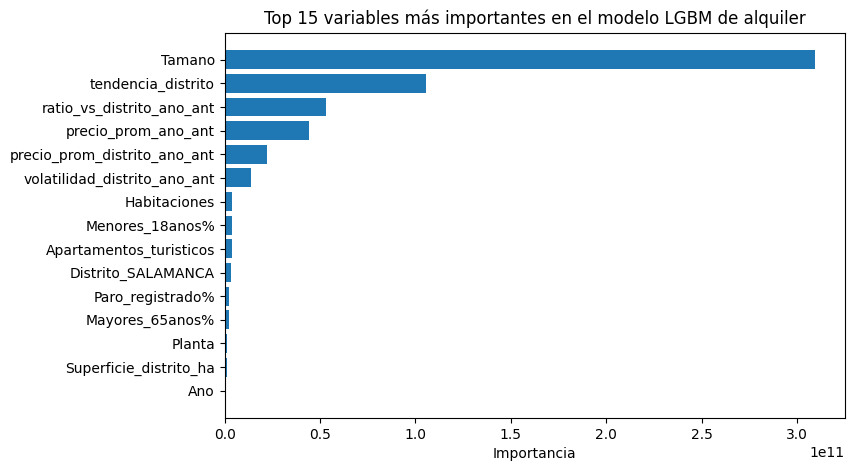

In [38]:
import matplotlib.pyplot as plt

for modelo in [lgbm_final_venta, lgbm_final_alquiler]:
    # Extraer importancias
    modelo_sin_pipeline = modelo.named_steps['modelo']
    importancias = modelo_sin_pipeline.booster_.feature_importance(importance_type='gain')
    if modelo == lgbm_final_venta:
        features = X_train_venta.columns
        operacion = 'venta'
    else:
        features = X_train_alquiler.columns
        operacion = 'alquiler'

    # Crear DataFrame ordenado
    imp_df = pd.DataFrame({
        'Variable': features,
        'Importancia': importancias
    }).sort_values(by='Importancia', ascending=False).head(15)

    # Mostrar tabla y gráfico
    display(imp_df)

    plt.figure(figsize=(8,5))
    plt.barh(imp_df['Variable'], imp_df['Importancia'])
    plt.gca().invert_yaxis()
    plt.title(f'Top 15 variables más importantes en el modelo LGBM de {operacion}')
    plt.xlabel('Importancia')
    plt.savefig(f'../reports/figures/importancia_variables_{operacion}.png', dpi=300, bbox_inches='tight')
    plt.show()

Evaluación en 2023 y 2024

Nulos en X_test (venta):
0

EVALUACIÓN FINAL EN TEST VENTA (2023-2024)
MAE:  26063.02
RMSE: 78165.51
R²:   0.9865
MAPE: 3.96%


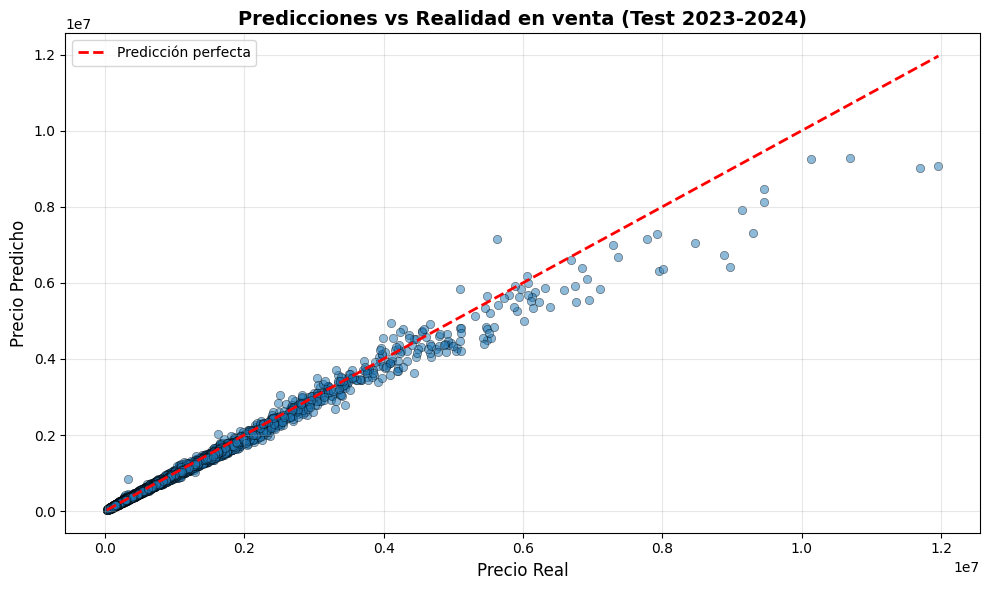

Nulos en X_test (alquiler):
0

EVALUACIÓN FINAL EN TEST ALQUILER (2023-2024)
MAE:  65.25
RMSE: 195.25
R²:   0.9803
MAPE: 2.60%


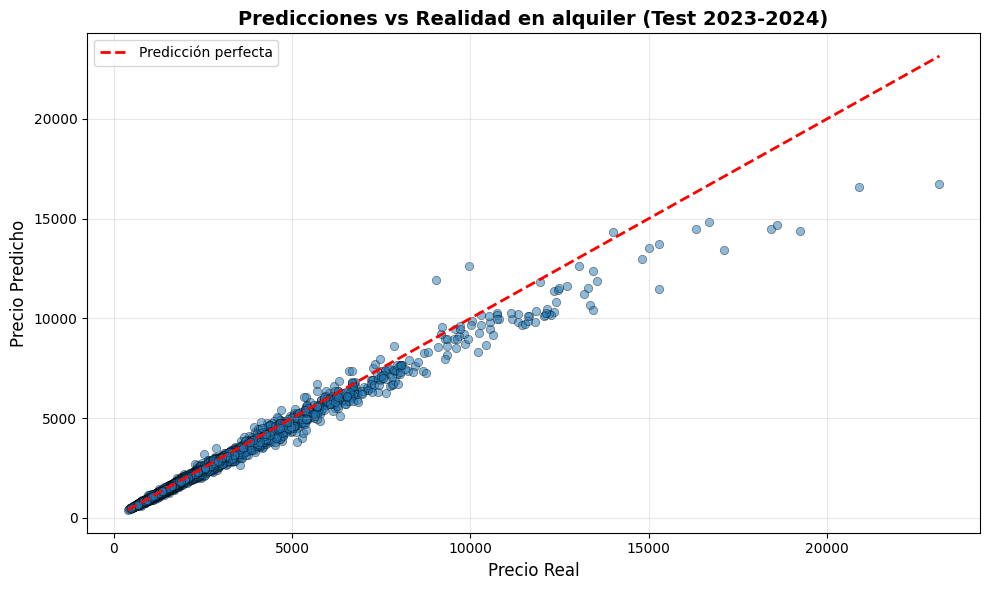

In [39]:
for modelo in [lgbm_final_venta, lgbm_final_alquiler]:
    if modelo == lgbm_final_venta:
        operacion = 'venta'
        X_train = X_train_venta
        X_test = X_test_venta
        y_test = y_test_venta
    else:
        operacion = 'alquiler'
        X_train = X_train_alquiler
        X_test = X_test_alquiler
        y_test = y_test_alquiler
    
    # Verificar que X_test no tenga nulos
    print(f"Nulos en X_test ({operacion}):")
    print(X_test.isna().sum().sum())

    # Si no hay nulos, evaluar directamente
    y_pred_test = modelo.predict(X_test)

    print("\n" + "="*50)
    print(f"EVALUACIÓN FINAL EN TEST {operacion.upper()} (2023-2024)")
    print("="*50)

    print(f"MAE:  {mean_absolute_error(y_test, y_pred_test):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}")
    print(f"R²:   {r2_score(y_test, y_pred_test):.4f}")

    # MAPE
    mape_test = np.mean(np.abs((y_test - y_pred_test) / (np.abs(y_test) + 1e-9))) * 100
    print(f"MAPE: {mape_test:.2f}%")

    # Comparación visual
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_test, alpha=0.5, edgecolors='k', linewidth=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Predicción perfecta')
    plt.xlabel('Precio Real', fontsize=12)
    plt.ylabel('Precio Predicho', fontsize=12)
    plt.title(f'Predicciones vs Realidad en {operacion} (Test 2023-2024)', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'../reports/figures/comparativa_predicciones_realidad_{operacion}.png', dpi=300, bbox_inches='tight')
    plt.show()

--- Análisis de errores en venta ---
Error medio: 16147.68 (sesgo)
Mediana del error absoluto: 10605.77
Percentil 90 del error relativo: 8.21%
% predicciones con error <10%: 95.0%
% predicciones con error >50%: 0.0%

Peores 10 predicciones:


,Real,Predicho,Error_abs,Error_rel_%
135660,1.196070e+07,9.063124e+06,2.897579e+06,24.225827
135535,1.170186e+07,9.014308e+06,2.687552e+06,22.966880
134451,8.969794e+06,6.406422e+06,2.563372e+06,28.577823
139124,8.880002e+06,6.741188e+06,2.138814e+06,24.085736
138166,9.305896e+06,7.321561e+06,1.984336e+06,21.323423
143568,8.015293e+06,6.352671e+06,1.662622e+06,20.743118
143196,7.947467e+06,6.320527e+06,1.626941e+06,20.471183
129507,5.620644e+06,7.162976e+06,1.542332e+06,27.440476
138165,8.462596e+06,7.050405e+06,1.412191e+06,16.687444
133331,1.068587e+07,9.275135e+06,1.410739e+06,13.201903


Rendimiento por rango de precio:



/tmp/ipykernel_1490/1070988635.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumen_rangos = df_errores.groupby('Rango').agg({


,MAE,Mediana_error,Error_rel_%_medio,Error_rel_%_mediano,n_casos
Rango,,,,,
<300k,7113.40,5202.98,3.82,2.92,8320
300-600k,15465.69,13362.95,3.63,3.11,4855
600k-1M,30627.32,25948.30,3.91,3.46,2570
1-2M,65581.48,55215.72,4.79,4.24,2091
>2M,238558.53,139531.79,6.14,5.22,540


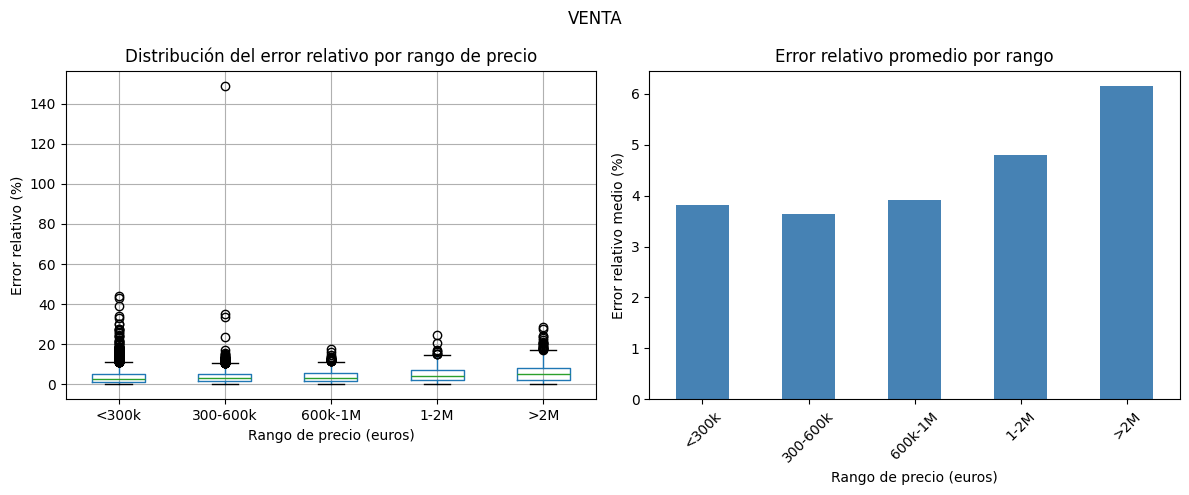

--- Análisis de errores en alquiler ---
Error medio: 49.70 (sesgo)
Mediana del error absoluto: 20.30
Percentil 90 del error relativo: 6.78%
% predicciones con error <10%: 96.5%
% predicciones con error >50%: 0.0%

Peores 10 predicciones:


,Real,Predicho,Error_abs,Error_rel_%
144251,23141.548404,16719.426510,6422.121893,27.751479
136895,19245.899024,14398.786728,4847.112296,25.185170
124243,20878.722225,16569.681433,4309.040792,20.638432
139083,18418.908110,14459.459826,3959.448284,21.496650
144205,18585.791253,14701.161965,3884.629288,20.901070
145388,15272.701577,11448.711136,3823.990441,25.038075
138731,17113.938854,13417.892294,3696.046560,21.596703
149423,13438.194702,10438.231976,2999.962726,22.324150
133312,9044.124013,11916.671997,2872.547984,31.761484
145408,13359.712005,10670.392160,2689.319845,20.130073


Rendimiento por rango de precio:



/tmp/ipykernel_1490/1070988635.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumen_rangos = df_errores.groupby('Rango').agg({


,MAE,Mediana_error,Error_rel_%_medio,Error_rel_%_mediano,n_casos
Rango,,,,,
<500,4.60,4.16,0.99,0.86,13
500-1000,12.63,7.51,1.47,0.92,2433
1000-1500,25.53,16.16,2.07,1.34,4070
1500-2000,42.40,25.96,2.44,1.52,2067
>2000,180.56,91.70,4.39,3.23,2929


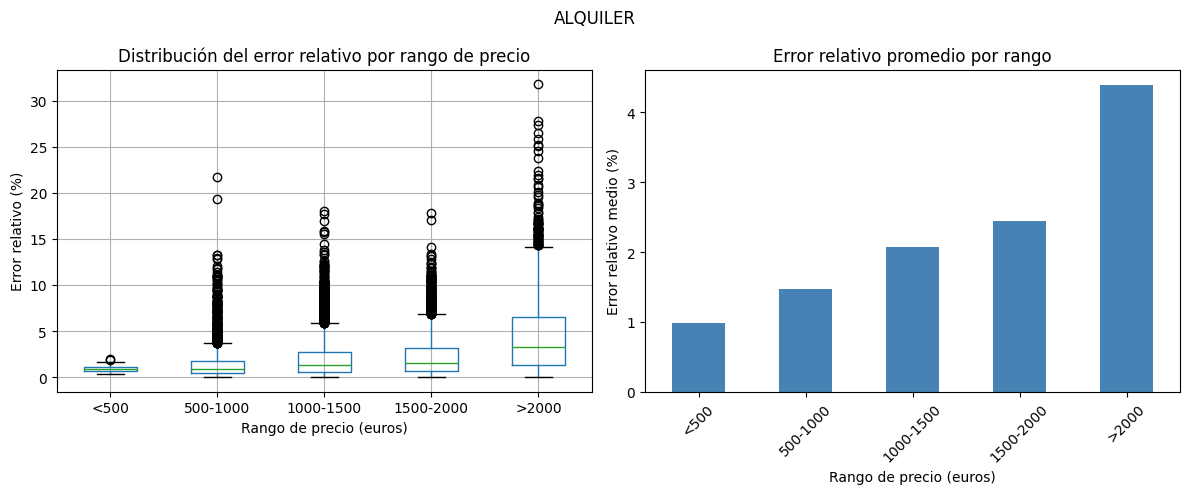

In [40]:
for modelo in [lgbm_final_venta, lgbm_final_alquiler]:
    if modelo == lgbm_final_venta:
        operacion = 'venta'
        X_train = X_train_venta
        X_test = X_test_venta
        y_test = y_test_venta
    else:
        operacion = 'alquiler'
        X_train = X_train_alquiler
        X_test = X_test_alquiler
        y_test = y_test_alquiler

    y_pred_test = modelo.predict(X_test)
    
    # Análisis de errores
    errores = y_test - y_pred_test
    errores_abs = np.abs(errores)
    errores_rel = np.abs(errores / y_test) * 100

    print(f"--- Análisis de errores en {operacion} ---")
    print(f"Error medio: {errores.mean():.2f} (sesgo)")
    print(f"Mediana del error absoluto: {np.median(errores_abs):.2f}")
    print(f"Percentil 90 del error relativo: {np.percentile(errores_rel, 90):.2f}%")
    print(f"% predicciones con error <10%: {(errores_rel < 10).mean() * 100:.1f}%")
    print(f"% predicciones con error >50%: {(errores_rel > 50).mean() * 100:.1f}%")

    # Identificar peores predicciones
    peores = pd.DataFrame({
        'Real': y_test,
        'Predicho': y_pred_test,
        'Error_abs': errores_abs,
        'Error_rel_%': errores_rel
    }).sort_values('Error_abs', ascending=False).head(10)

    print("\nPeores 10 predicciones:")
    display(peores)

    # --- VISUALIZACIÓN ---
    # Crear rangos de precio
    if operacion == 'venta':
        bins = [0, 300000, 600000, 1000000, 2000000, np.inf]
        labels = ['<300k', '300-600k', '600k-1M', '1-2M', '>2M']
    else:
        bins = [0, 500, 1000, 1500, 2000, np.inf]
        labels = ['<500', '500-1000', '1000-1500', '1500-2000', '>2000']

    df_errores = pd.DataFrame({
        'Real': y_test.values,
        'Predicho': y_pred_test,
        'Error_abs': errores_abs,
        'Error_rel_%': errores_rel
    })

    df_errores['Rango'] = pd.cut(df_errores['Real'], bins=bins, labels=labels)

    # Análisis por rango
    print("Rendimiento por rango de precio:\n")
    resumen_rangos = df_errores.groupby('Rango').agg({
        'Error_abs': ['mean', 'median'],
        'Error_rel_%': ['mean', 'median'],
        'Real': 'count'
    }).round(2)

    resumen_rangos.columns = ['MAE', 'Mediana_error', 'Error_rel_%_medio', 'Error_rel_%_mediano', 'n_casos']
    display(resumen_rangos)

    # Visualizar errores por rango
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    df_errores.boxplot(column='Error_rel_%', by='Rango', ax=plt.gca())
    plt.title('Distribución del error relativo por rango de precio')
    plt.ylabel('Error relativo (%)')
    plt.xlabel('Rango de precio (euros)')
    plt.suptitle(f'{operacion.upper()}')

    plt.subplot(1, 2, 2)
    resumen_rangos['Error_rel_%_medio'].plot(kind='bar', color='steelblue')
    plt.title('Error relativo promedio por rango')
    plt.ylabel('Error relativo medio (%)')
    plt.xlabel('Rango de precio (euros)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig(f'../reports/figures/errores_modelo_{operacion}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [34]:
def evaluar_sin_fit(model, X_tr, y_tr, X_va, y_va):
    pred_tr = model.predict(X_tr)
    pred_va = model.predict(X_va)

    return {
        "MAE_train": mean_absolute_error(y_tr, pred_tr),
        "RMSE_train": np.sqrt(mean_squared_error(y_tr, pred_tr)),
        "R2_train": r2_score(y_tr, pred_tr),
        "MAE_val": mean_absolute_error(y_va, pred_va),
        "RMSE_val": np.sqrt(mean_squared_error(y_va, pred_va)),
        "MAPE_val_%": mean_absolute_percentage_error(y_va, pred_va) * 100,
        "R2_val": r2_score(y_va, pred_va),
    }

In [36]:
for modelo in [lgbm_final_venta, lgbm_final_alquiler]:
    if modelo == lgbm_final_venta:
        operacion = 'venta'
        X_train = X_train_venta
        X_test = X_test_venta
        y_test = y_test_venta
        y_train = y_train_venta
    else:
        operacion = 'alquiler'
        X_train = X_train_alquiler
        X_test = X_test_alquiler
        y_test = y_test_alquiler
        y_train = y_train_alquiler

    print("\n--- Evaluación en 2023 ---")
    eval_2023 = evaluar_sin_fit(modelo, X_train, y_train,
                        X_test.loc[df["Ano"] == 2023],
                        y_test.loc[df["Ano"] == 2023])
    print(eval_2023)

    print("\n--- Evaluación en 2024 ---")
    eval_2024 = evaluar_sin_fit(modelo, X_train, y_train,
                        X_test.loc[df["Ano"] == 2024],
                        y_test.loc[df["Ano"] == 2024])
    print(eval_2024)


--- Evaluación en 2023 ---
{'MAE_train': 4727.820724262678, 'RMSE_train': np.float64(6931.403107739693), 'R2_train': 0.9998267494644445, 'MAE_val': 18815.194343303763, 'RMSE_val': np.float64(53987.72348716099), 'MAPE_val_%': 3.2745545888121472, 'R2_val': 0.9926527896636059}

--- Evaluación en 2024 ---
{'MAE_train': 4727.820724262678, 'RMSE_train': np.float64(6931.403107739693), 'R2_train': 0.9998267494644445, 'MAE_val': 33310.85551434571, 'RMSE_val': np.float64(96462.53016761746), 'MAPE_val_%': 4.649988181150244, 'R2_val': 0.9817096339824796}

--- Evaluación en 2023 ---
{'MAE_train': 5.308798613189499, 'RMSE_train': np.float64(8.09025592914751), 'R2_train': 0.999944977223825, 'MAE_val': 46.88994465984222, 'RMSE_val': np.float64(135.4174815267141), 'MAPE_val_%': 2.075933128582656, 'R2_val': 0.9890970731921405}

--- Evaluación en 2024 ---
{'MAE_train': 5.308798613189499, 'RMSE_train': np.float64(8.09025592914751), 'R2_train': 0.999944977223825, 'MAE_val': 83.61304534730161, 'RMSE_val': 